# Lab 4: Chronos - learning the language of time series
This notebook uses content from [Chronos GitHub](https://github.com/amazon-science/chronos-forecasting).

Chronos is a family of pretrained time series forecasting models based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss.

Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes.

Chronos demonstrates impressive zero-shot forecasting performance across a wide range of datasets. More specifically, it achieves comparable and occasionally superior zero-shot performance on new datasets, relative to methods that were trained specifically on those datasets. In a comprehensive evaluation across 42 datasets, see [1](https://arxiv.org/html/2403.07815v1) and [2](https://www.amazon.science/blog/adapting-language-model-architectures-for-time-series-forecasting), Chronos establishes itself as a benchmark for zero-shot forecasting, surpassing both traditional models and task-specific deep learning approaches. Chronos can leverage time series data from diverse domains to improve zero-shot accuracy on unseen forecasting tasks.

For details on Chronos models, training data and procedures, and experimental results, please refer to the paper [Chronos: Learning the Language of Time Series](https://arxiv.org/abs/2403.07815).

## Architecture
Chronos models are based on the [T5 architecture](https://arxiv.org/abs/1910.10683). The only difference is in the vocabulary size: Chronos-T5 models use 4096 different tokens, compared to 32128 of the original T5 models, resulting in fewer parameters. The following table provides links to corresponding Chronos models on Huggingface model hub.

|Model|Parameters|Based on|
|---|---|---|
|[**chronos-t5-tiny**](https://huggingface.co/amazon/chronos-t5-tiny)|8M|[t5-efficient-tiny](https://huggingface.co/google/t5-efficient-tiny)|
|[**chronos-t5-mini**](https://huggingface.co/amazon/chronos-t5-mini)|20M|[t5-efficient-mini](https://huggingface.co/google/t5-efficient-mini)|
|[**chronos-t5-small**](https://huggingface.co/amazon/chronos-t5-small)|46M|[t5-efficient-small](https://huggingface.co/google/t5-efficient-small)|
|[**chronos-t5-base**](https://huggingface.co/amazon/chronos-t5-base)|200M|[t5-efficient-base](https://huggingface.co/google/t5-efficient-base)|
|[**chronos-t5-large**](https://huggingface.co/amazon/chronos-t5-large)|710M|[t5-efficient-large](https://huggingface.co/google/t5-efficient-large)|

The following diagram from the Chronos GitHub shows the high-level architecture of Chronos:

![](../img/chronos-main-figure.png)

## Zero-shot inference

This notebooks demonstrate how to use a pretrained Chronos model for **zero-shot** inference for predicting time series. Unlike local statistical models or task-specific models that you need to train on particular historical datasets, Chronos generates zero-shot probobalistic forecaset for time series that its models have never seen during training.

## Recommended usage
The recommended way of using Chronos for production use cases is through [AutoGluon](https://auto.gluon.ai/), which features ensembling with other statistical and machine learning models for time series forecasting as well as seamless deployments on AWS with SageMaker. The next [notebook](./lab5_autogluon.ipynb) in this workshop demonstrates usage of AutoGluon for time series forecast including Chronos.

This notebooks shows how to use Chronos models hosted as SageMaker real-time endpoints.

---

## Import packages

In [2]:
%pip install -Uq s3fs sagemaker

Note: you may need to restart the kernel to use updated packages.


In [220]:
import json
import sagemaker
from sagemaker.jumpstart.model import JumpStartModel
import boto3
import zipfile
from dateutil.parser import parse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threading
import tqdm
import asyncio
import time
from time import gmtime, strftime, sleep
from IPython.display import HTML
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import (
interact, interactive, fixed, interact_manual,
IntSlider, FloatSlider, Checkbox, Dropdown, DatePicker, SelectMultiple, Checkbox
)

%matplotlib inline

## Set literals and general variables

In [4]:
%store -r
%store

try:
    domain_id
except NameError:
    print("""\033[91m 
    **************************************************************************************
    domain_id is not defined!
    Set it manually or run the "Setup notebook environment" section of the lab 1 notebook
    **************************************************************************************
    \033[0m""")

Stored variables and their in-db values:
domain_id                     -> 'd-bxyhco2o9dpc'
region                        -> 'us-east-1'
space_name                    -> 'sagemaker-space'
user_profile_name             -> 'studio-user-ts-0f6b7e60'


In [5]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
sm = boto3.client("sagemaker")

In [6]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "chronos-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "chronos"

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [7]:
s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [8]:
dataset_zip_file_name = "LD2011_2014.txt.zip"
s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [9]:
os.makedirs("./data", exist_ok=True)

s3_client = boto3.client("s3")
s3_client.download_file(
    f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"./data/{dataset_zip_file_name}"
)

In [10]:
zip_ref = zipfile.ZipFile(f"./data/{dataset_zip_file_name}", "r")
zip_ref.extractall("./data")
zip_ref.close()
dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])

In [11]:
# see what is inside the file
# !head -n 2 {dataset_path} 

## Explore and preprocess data

In [12]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [13]:
df_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


The following code resamples the dataset to 1H intervals to reduce the number of data points and smoothen the data. You can experiment with any other sampling interval. Remember to ajust the divider for resampled kW data.

In [14]:
# resample to 2h intervals
freq = "2H"
div = 8 # 2 hours contain 8x 15 min intervals, you need to  delete the resampled value by 8
num_timeseries = df_raw.shape[1]
data_kw = df_raw.resample(freq).sum() / div
timeseries = []

for i in tqdm.trange(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

100%|██████████| 370/370 [00:00<00:00, 1214.04it/s]


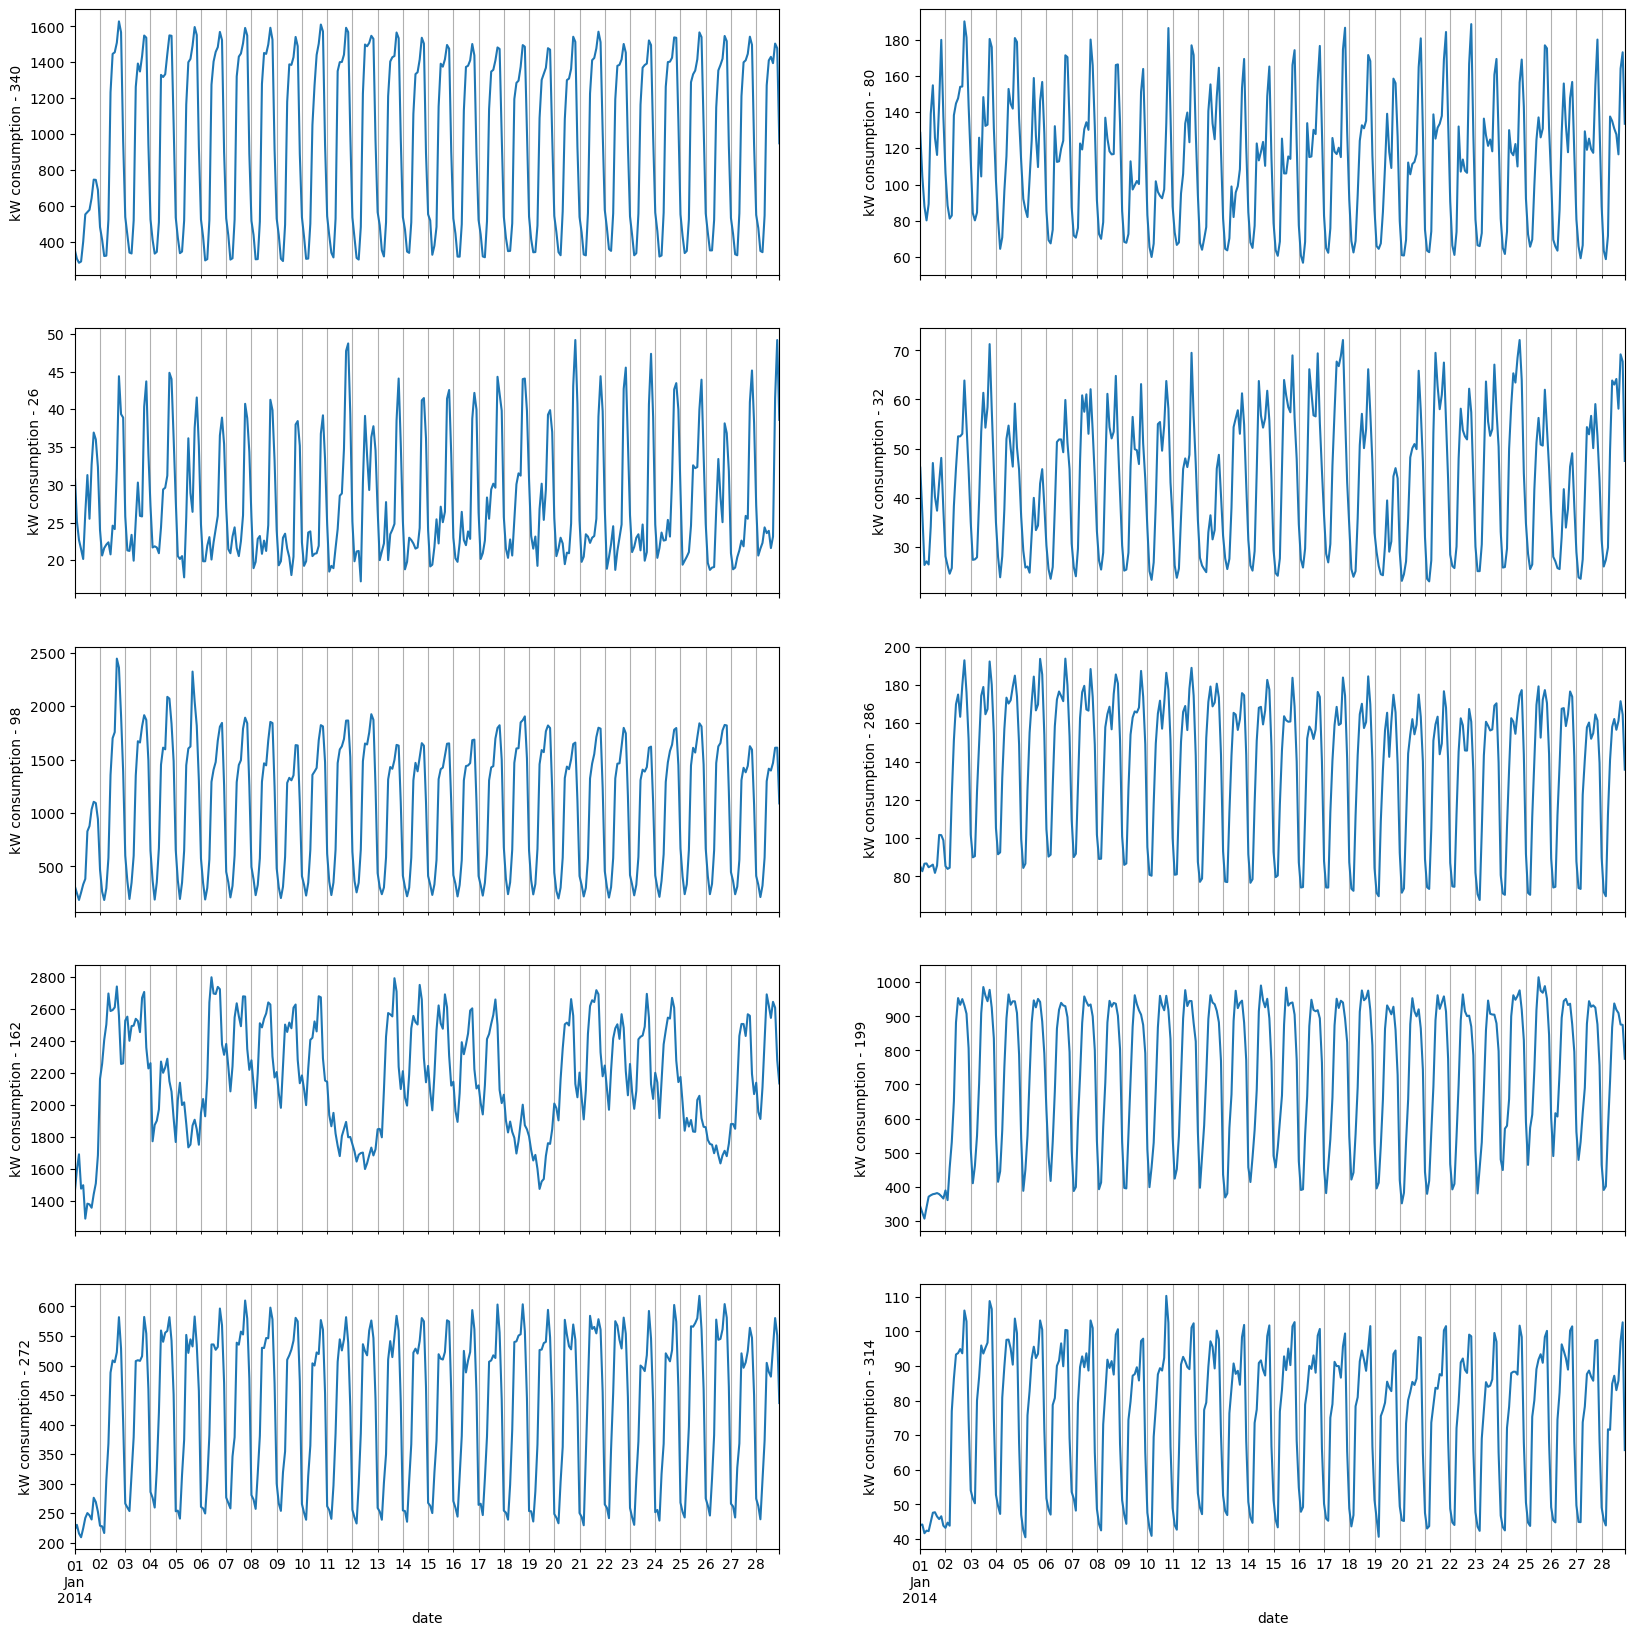

In [15]:
# show random 10 timeseries for 28 day period
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i, ts_id in enumerate(np.random.randint(1, data_kw.shape[1], size=10).tolist()):
    timeseries[ts_id].loc["2014-01-01":"2014-01-28"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel(f"kW consumption - {ts_id}")
    axx[i].grid(which="minor", axis="x")

Create a smaller dataset with a subset of time series:

In [112]:
# select two random time series to include in a small dataset
size = 2
columns_to_keep = np.random.randint(1, data_kw.shape[1], size=size).tolist()
columns_to_keep

[366, 323]

In [113]:
data_kw_small = data_kw.iloc[:, columns_to_keep]
data_kw_small

,MT_367,MT_324
2011-01-01 00:00:00,0.000000,205.633803
2011-01-01 02:00:00,0.000000,225.950704
2011-01-01 04:00:00,0.000000,228.371479
2011-01-01 06:00:00,0.000000,248.191021
2011-01-01 08:00:00,0.000000,274.185739
...,...,...
2014-12-31 16:00:00,504.938543,410.255282
2014-12-31 18:00:00,500.877963,431.659331
2014-12-31 20:00:00,420.654083,298.514525
2014-12-31 22:00:00,665.605795,262.070863


In [18]:
# timeseries_small = []
# for i in tqdm.trange(data_kw_small.shape[1]):
#     timeseries_small.append(np.trim_zeros(data_kw_small.iloc[:, i], trim="f"))

## Deploy Chronos models
This notebook uses the [`JumpStartModel`](https://docs.aws.amazon.com/sagemaker/latest/dg/jumpstart-foundation-models-use-python-sdk.html) class in the SageMaker Python SDK. SageMaker JumpStart models can be deployed using the model ID. 

You can also deploy a Chronos model directly from the Studio UI. For example, open the link constructed by the following code cell to see a Chronos model in the SageMaker JumpStart.

This notebook uses SageMaker Python SDK to deploy three Chronos models as SageMaker real-time inference endpoints.

In [19]:
# Show the JumpStart model link
model_to_show = 'chronos-t5-small'
display(
    HTML('<b>See <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/jumpstart/SageMakerPublicHub/Model/autogluon-forecasting-{}">JumpStart Chronos model</a> in the Studio UI</b>'.format(
            domain_id, region, model_to_show))
)

You need an GPU-instance for an endpoint to run Chronos `large`, `base`, and `small` models. You can run `mini` and `tiny` models on a CPU-based instance.

### Check quotas for endpoint instances
Before deploying models, you need to check if you have an account-level quota for the specific GPU-instances like `ml.g5.*`.

In [20]:
def check_quota(models):
    quotas_client = boto3.client("service-quotas")

    for m in models:
        r = quotas_client.get_service_quota(
            ServiceCode="sagemaker",
            QuotaCode=m["quota_code"],
        )
    
        q = r["Quota"]["Value"]
        n = r["Quota"]["QuotaName"]
        min_n = m["min_number"] if m.get("min_number") else 1

        print(f"WARNING: Quota {q} for {n} < required {min_n}" if q < min_n else f"SUCCESS: Quota {q} for {n} >= required {min_n}")
        

The following dictionary defines which models this notebooks is going to deploy and what ML instances is used. If you don't have sufficient quota for the corresponding ML instance, set the value of `deploy` key to `False`. As a minimal setup, you can deploy only the `chronos-t5-small` model to experiment with the inference.

In [21]:
model_map = [
    {"model":"chronos-t5-small",
     "instance":"ml.g5.xlarge",
     "quota_code":"L-1928E07B",
     "deploy": True
    },
    {"model":"chronos-t5-base",
     "instance":"ml.g5.2xlarge",
     "quota_code":"L-9614C779",
     "deploy": False
    },
    {"model":"chronos-t5-large",
     "instance":"ml.g5.4xlarge",
     "quota_code":"L-C1B9A48D",
     "deploy": False
    },
]

In [22]:
# check if you have account-level quota for the required inference instance
check_quota(model_map)

SUCCESS: Quota 4.0 for ml.g5.xlarge for endpoint usage >= required 1
SUCCESS: Quota 2.0 for ml.g5.2xlarge for endpoint usage >= required 1
SUCCESS: Quota 2.0 for ml.g5.4xlarge for endpoint usage >= required 1


<div class="alert alert-info">
If you using an AWS-provisioned workshop account, you cannot change quotas. If you don't have sufficient quotas for <code>ml.g5.*</code>, try <code>ml.g4dn.2xlarge </code> or <code>ml.g4dn.4xlarge </code> instances.
</div>

### Custom predictor class
Implement a wrapper for the Chronos predictor to conveniently pass Pandas series to the predictor and convert the response also to Pandas series.

Chronos model interface receives the following JSON as the input. You specify target time series and inference parameters like prediction length and quantiles to generate:

```
{
    "inputs": [
        {"target": [0.0, 4.0, 5.0, 1.5, -3.0, -5.0, -3.0, 1.5, 5.0, 4.0, 0.0, -4.0, -5.0, -1.5, 3.0, 5.0, 3.0, -1.5, -5.0, -4.0]}
    ],
    "parameters": {
        "prediction_length": 10,
        "quantile_levels": [0.1, 0.5, 0.9]
    }
}
```

The model output is a JSON document which contains the predicted time series per quantile and the mean prediction:
```
{
    "predictions": [
        {
            "mean": [-0.0, 3.5, 4.2, 1.7, -1.5, -3.5, -1.9, 1.3, 3.8, 3.4],
            "0.1": [-2.4, 1.5, 2.2, 0.0, -4.9, -5.0, -4.9, -1.5, 1.4, 0.9],
            "0.5": [-0.0, 3.0, 4.0, 1.5, -1.5, -4.9, -2.8, 1.5, 4.5, 3.0],
            "0.9": [1.7, 5.6, 5.5, 3.1, 0.4, 0.0, 3.0, 3.2, 5.0, 5.0]
        }
    ]
}
```

The following code implements a custome predictor class derived from the SageMaker Python SDK [`Predictor`](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor).

In [23]:
from sagemaker.serializers import IdentitySerializer

class ChronosPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts_list,
        prediction_length=64,
        quantiles=[0.10, 0.5, 0.90],
    ):
        """Requests the prediction of for the time series listed in `ts`
        ts_list -- list of `pandas.Series` objects, the time series to predict
        prediction_length -- number of data points to predict, dimension is the sampling interval
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
    
        Return value: list of `pandas.DataFrame` objects containing the predictions
        """
        prediction_start = ts_list[0].index[-1] + ts_list[0].index.freq
        req = self.__encode_request(ts_list, prediction_length, quantiles)
            
        res = super(ChronosPredictor, self).predict(req)
        
        return self.__decode_response(res, ts_list[0].index.freq, prediction_start)

    def __encode_request(self, ts_list, prediction_length, quantiles):
        parameters = {
            "parameters": {
                "prediction_length": prediction_length,
                "quantile_levels": quantiles,
            }
        }
    
        inputs = {"inputs":[series_to_dict(ts) for ts in ts_list]}
    
        http_request_data = {**inputs, **parameters}
    
        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_start):
        # Chronos supports multiple time series in the inference request
        predictions = json.loads(response.decode("utf-8"))["predictions"]
        prediction_index = pd.date_range(
            start=prediction_start, freq=freq, periods=len(predictions[0]["mean"])
        )
    
        return [pd.DataFrame(
            data=p, index=prediction_index
            ) for p in predictions]

def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]

def series_to_dict(ts):
    return {"target": encode_target(ts), "item_id": ts.name}

### Deploy endpoints
Now use `JumpStartModel` and the custome `ChronosPredictor` to create and deploy Chronos models. For the full list of available model ids for JumpStart refer to [Built-in Algorithms with pre-trained Model Table
](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html) in SageMaker Python SDK documentation.

In [24]:
chronos_predictors = {}

for m in model_map:
    if m['deploy']:
        model = JumpStartModel(
            model_id="autogluon-forecasting-" + m["model"],
            model_version="1.0.0",
            predictor_cls=ChronosPredictor,
        )
    
        print(f"Start deploying {m['model']} on {m['instance']}")
        chronos_predictors[m["model"]] =  model.deploy(
            instance_type=m["instance"],  # single-GPU g5, p3, g4dn instances supported
            wait=False,
        )

Start deploying chronos-t5-small on ml.g5.xlarge


Wait until all endpoints are in service. The deployment takes about 5-7 minutes.

In [41]:
%%time

# Wait until all endpoints have the status InService
for p in chronos_predictors.values():
    waiter = sagemaker_session.sagemaker_client.get_waiter('endpoint_in_service')
    waiter.wait(EndpointName=p.endpoint_name)

CPU times: user 14 ms, sys: 15.8 ms, total: 29.8 ms
Wall time: 144 ms


## Using Chronos real-time endpoints

### Generate predictions
Run a sample prediction to test an endpoint.

In [42]:
assert(len(chronos_predictors.values()) > 0)

In [43]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 12
prediction_length = prediction_days * intervals_per_day
context_length = prediction_length * 10
forecast_quantiles = [0.10, 0.5, 0.90]

In [44]:
ts = timeseries[0][len(timeseries[0])-context_length:]

In [45]:
ts

2014-10-09 02:00:00    1.903553
2014-10-09 04:00:00    2.062183
2014-10-09 06:00:00    1.744924
2014-10-09 08:00:00    1.744924
2014-10-09 10:00:00    1.110406
                         ...   
2014-12-31 16:00:00    2.379442
2014-12-31 18:00:00    2.220812
2014-12-31 20:00:00    2.379442
2014-12-31 22:00:00    2.062183
2015-01-01 00:00:00    0.317259
Freq: 2H, Name: MT_001, Length: 1008, dtype: float64

Chronos generates a forecast for `prediction_length` data points starting from the end of the provided time series:

In [46]:
list(chronos_predictors.values())[0].predict(
    [ts],
    prediction_length,
    forecast_quantiles
)[0]

,mean,0.1,0.5,0.9,item_id
2015-01-01 02:00:00,1.025463,0.324074,0.555556,2.854938,MT_001
2015-01-01 04:00:00,1.342592,0.324074,1.111111,2.702161,MT_001
2015-01-01 06:00:00,1.231481,0.324074,1.033951,2.870370,MT_001
2015-01-01 08:00:00,1.048611,0.154321,0.632716,2.408951,MT_001
2015-01-01 10:00:00,0.820988,0.154321,0.555556,1.822531,MT_001
...,...,...,...,...,...
2015-01-07 16:00:00,1.714758,1.064490,1.827451,2.238628,MT_001
2015-01-07 18:00:00,1.855624,0.776667,1.956896,2.392438,MT_001
2015-01-07 20:00:00,1.819075,0.759915,2.086340,2.392438,MT_001
2015-01-07 22:00:00,1.843441,0.472092,2.078726,2.695490,MT_001


### Vizualize predictions
Define a plotting function that sends an input time series to the endpoint and then plots the generated result. 
Note, that all `*_length` parameters are in the **units of aggregation interval**. For example, for `2H` aggregation, if you'd like to generate a forecast for one day, you need 24/2=12 data points. To predict 7 days in 2H intervals, set the `prediction_length` to 7*12=84.

In [47]:
start_dataset = pd.Timestamp("2011-01-01 00:00:00", unit=freq)
end_dataset = pd.Timestamp("2014-12-31 00:00:00", unit=freq)

In [67]:
# plot an individual time series
def plot_series(
    input_ts,
    prediction_ts,
    low_quantile,
    up_quantile,
    ax,
):
    ax.set_title(f"{input_ts.name}")
    input_ts.plot(ax=ax, color="black", label="target")

    # plot the confidence interval p90-p10, p50, and the mean predicted
    ax.fill_between(
        prediction_ts[low_quantile].index,
        prediction_ts[low_quantile].values,
        prediction_ts[up_quantile].values,
        color="b",
        alpha=0.3,
        label="{}% confidence interval".format(80),
    )
    prediction_ts['mean'].plot(ax=ax, color="r", label="mean")
    prediction_ts['0.5'].plot(ax=ax, color="b", label="P50")
    ax.legend(loc='upper left')

    # fix the scale as the samples may change it
    ax.set_ylim(input_ts.min() * 0.5, input_ts.max() * 1.5)

# plot all input time series and all predictions
def plot(
    predictor,
    ts_list,
    context_end=end_dataset,
    context_length=512,
    prediction_length=prediction_length,
    show_history_length=prediction_length*3,
    display_data=False,
):
    freq = ts_list[0].index.freq

    # construct a list of pandas.Series to send to the predictor
    inference_ts = [ts[context_end - context_length*freq : context_end] for ts in ts_list]

    prediction_start = inference_ts[0].index[-1] + inference_ts[0].index.freq
    print(f"calling the endpoint to generate predictions starting from {str(prediction_start)}")

    if display_data:
        print(f"""
        Input data:
        {inference_ts}
        """)

    # call the end point to get the prediction
    predictions = predictor.predict(
        ts_list=inference_ts,
        prediction_length=prediction_length,
        quantiles=forecast_quantiles
    )

    if display_data:
        print(f"""
        Model output:
        {predictions}
        """)

    n_ts = len(predictions)
    fig, axs = plt.subplots(n_ts, 1, figsize=(20, 7*n_ts))
    axx = [axs] if n_ts == 1 else axs.ravel()

    for i, prediction in enumerate(predictions):
        plot_series(
            ts_list[i][context_end - show_history_length*freq : context_end + prediction_length * freq],
            prediction,
            '0.1',
            '0.9',
            axx[i],
        )

    plt.tight_layout()
    plt.show()

Experiment with different Chronos model sizes, time series, context lengths, and prediction lengths to generate predictions. You can change the following parameters:

- `Model`: size of the Chronos model. The input is sent to the corresponding deployed model
- `Time series ids`: ids of the time series in the full dataset. You can select multiple time series to predict and to plot  
- `Predict from`: start of the prediction interval  
- `Context length`: how many data points are sent to the model  
- `Prediction length`: lenght of the predicted time series in frequency units
- `History lenght`: how many 'prediction lengths' of history are shown on the plot as the history time series
- `Show datasets`: turn on this option if you would like to see the input and output datasets  

In [68]:
style = {"description_width": "initial"}
ts_id_list = [ts.name for ts in timeseries]

In [69]:
@interact_manual(
    predictor=Dropdown(options=list(chronos_predictors.keys()), description='Model:'),
    ts_ids=SelectMultiple(options=ts_id_list, value=[ts_id_list[0]], rows=5, style=style, description='Time series ids:'),
    context_end=DatePicker(value=end_dataset, style=style, description='Predict from:'),
    context_length=IntSlider(min=prediction_length, max=4096, value=prediction_length*4, style=style, description='Context length:'),
    prediction_length=IntSlider(min=1, max=prediction_length*4, value=prediction_length, style=style, description='Prediction length:'),
    history_length=IntSlider(min=1, max=10, value=3, style=style, description='History length:'),
    display_data = Checkbox(value=False, style=style, description='Display datasets:'),
    continuous_update=False,
)
def plot_interact(predictor, ts_ids, context_end, context_length, prediction_length, history_length, display_data):
    plot(
        predictor=chronos_predictors[predictor],
        ts_list=[ts for ts in timeseries if ts.name in ts_ids],
        context_end=context_end,
        context_length=context_length,
        prediction_length=prediction_length,
        show_history_length=history_length*prediction_length,
        display_data=display_data,
    )

interactive(children=(Dropdown(description='Model:', options=('chronos-t5-small',), value='chronos-t5-small'),…

## Chronos model performance

In this section you evaluate performance of Chronos models using the deployed real-time inference endpoints and backtesting.

To minimize writing of boilerplate code for time series processing and evaluation, this notebook uses [AutoGluon](https://auto.gluon.ai/) library, more specifically `TimeSeriesDataFrame` and `TimeSeriesPredictor` classes. 

First, you need to install `autogluon` package.

In [25]:
!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
%pip install -q fsspec

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.19.2 requires fsspec[http]<=2024.3.1,>=2023.1.0, but you have fsspec 2024.9.0 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.9.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [26]:
%pip install -Uq autogluon

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.3.1 which is incompatible.
s3fs 2024.9.0 requires fsspec==2024.9.0.*, but you have fsspec 2024.3.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Import required packages and classes:

In [183]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.splitter import ExpandingWindowSplitter
from autogluon.timeseries.metrics.quantile import WQL
from autogluon.timeseries.metrics import (WAPE, MAPE, MASE, RMSE)

from importlib.metadata import version
print(version('autogluon'))

1.1.1


Create helper functions you need to convert between `Pandas.Series` and `TimeSeriesDataFrame`.

In [160]:
# converts a Pandas.DataFrame to AutoGluon TimeSeriesDataFrame
# note the function hardcodes column names and work only with the dataset in this notebook
def get_ts_df(
    df,
) ->  TimeSeriesDataFrame: 
    # Convert to an AutoGluon TimeSeriesDataFrame
    return TimeSeriesDataFrame.from_data_frame(
        # Melt the DataFrame into the long format
        pd.melt(
            df.reset_index(),
            id_vars='index', 
            value_vars=ts_wide_df.columns, 
            var_name='item_id', 
            value_name='target'
        ).rename(columns={'index': 'timestamp'}), # Rename the 'index' column to 'timestamp'
        id_column="item_id",
        timestamp_column="timestamp",
    )

In [161]:
# converts AutoGluon TimeSeriesDataFrame to Pandas.Series
def get_item_series(
    ts_df: TimeSeriesDataFrame,
    target: str = 'target',
):
    series = []

    for item_id in ts_df.item_ids:
        # Get the time series for this item
        item_series = ts_df.loc[item_id]
        
        # Convert to a Pandas Series
        series.append(
            pd.Series(
                item_series[target].values,
                index=pd.DatetimeIndex(item_series.index, freq=ts_df.freq),
                name=item_id,
            )
        )

    return series

In [162]:
# wrapper for Chronos predictor to use TimeSeriesDataFrame as input and output
def predict_ag(
    data: TimeSeriesDataFrame,
    model: str = None,
    prediction_length: int = 64,
    quantiles = [0.10, 0.5, 0.90],
    display_details = True,
) -> TimeSeriesDataFrame:

    model = model if model else list(chronos_predictors.keys())[0]
    predictor = chronos_predictors[model]
    if display_details:
        print(f"Using Chronos model: {model}, number of time series: {data.num_items} , context length: {data.num_timesteps_per_item()[data.item_ids[0]]}, prediction length: {prediction_length}")

    return TimeSeriesDataFrame.from_data_frame(
        pd.concat(
            # call Chronos predictor
            predictor.predict(
                ts_list=get_item_series(data),
                prediction_length=prediction_length,
                quantiles=quantiles,
            )
        ).reset_index().rename(columns={'index':'timestamp'}),
        id_column="item_id",
        timestamp_column="timestamp",
    )

### Convert data to AutoGluon format
First you need to convert time series to `TimeSeriesDataFrame`. The next notebok `lab5_autogluon` has more details on the `TimeSeriesDataFrame`. Refer also to [TimeSeriesDataFrame](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html) documenationt for specific details.

`TimeSeriesDataFrame` inherits from [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), so all attributes and methods of `pandas.DataFrame` are available in a `TimeSeriesDataFrame`. It also provides useful utility functions, such as loaders for different data formats, slicing by time or time step, and train-test split.

The following code uses a subset with two random time series of the full dataset.

In [172]:
ts_sample_df = get_ts_df(data_kw_small)
ts_sample_df

target
item_id timestamp                      
MT_367  2011-01-01 00:00:00    0.000000
        2011-01-01 02:00:00    0.000000
        2011-01-01 04:00:00    0.000000
        2011-01-01 06:00:00    0.000000
        2011-01-01 08:00:00    0.000000
...                                 ...
MT_324  2014-12-31 16:00:00  410.255282
        2014-12-31 18:00:00  431.659331
        2014-12-31 20:00:00  298.514525
        2014-12-31 22:00:00  262.070863
        2015-01-01 00:00:00   27.803697

[35066 rows x 1 columns]

### Predict using `TimeSeriesDataFrame`
Now you can use `TimeSeriesDataFrame` to slice time series and run prediction with the deployed Chronos end points. For example, to get a slice for inference of the size `context_length`, use the [`slice_by_timestep()`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.slice_by_timestep.html) method:

In [265]:
context_length = prediction_length*2

In [266]:
inference_df = ts_sample_df.slice_by_timestep(
    start_index=-context_length-prediction_length,
    end_index=-prediction_length-1
)

In [267]:
inference_df

target
item_id timestamp                      
MT_367  2014-12-11 02:00:00  594.051800
        2014-12-11 04:00:00  569.578578
        2014-12-11 06:00:00  507.462687
        2014-12-11 08:00:00  460.820896
        2014-12-11 10:00:00  444.578578
...                                 ...
MT_324  2014-12-24 14:00:00  388.631162
        2014-12-24 16:00:00  400.105634
        2014-12-24 18:00:00  451.305018
        2014-12-24 20:00:00  423.501320
        2014-12-24 22:00:00  374.504842

[334 rows x 1 columns]

In [268]:
# the total number of rows in the slice
(context_length-1)*ts_sample_df.num_items

334

Call the Chronos endpoint:

In [269]:
%%time
prediction_df = predict_ag(
    inference_df,
    prediction_length=prediction_length
)

Using Chronos model: chronos-t5-small, number of time series: 2 , context length: 167, prediction length: 84
CPU times: user 22.3 ms, sys: 1.14 ms, total: 23.4 ms
Wall time: 776 ms


In [270]:
prediction_df

mean         0.1         0.5         0.9
item_id timestamp                                                          
MT_367  2014-12-25 00:00:00  668.576050  616.134607  660.144257  720.606055
        2014-12-25 02:00:00  597.214600  506.316260  604.618103  663.846021
        2014-12-25 04:00:00  514.747925  417.474393  530.583191  568.423254
        2014-12-25 06:00:00  473.823151  389.094345  489.452744  522.768420
        2014-12-25 08:00:00  439.890472  390.739563  440.096161  478.347528
...                                 ...         ...         ...         ...
MT_324  2014-12-31 14:00:00  383.052551  365.787177  382.219025  405.080704
        2014-12-31 16:00:00  390.911255  371.502579  386.981888  412.701276
        2014-12-31 18:00:00  436.039246  405.557001  440.563980  460.329819
        2014-12-31 20:00:00  414.963623  393.173578  415.558990  438.658841
        2014-12-31 22:00:00  358.761963  330.065771  358.404755  384.362329

[168 rows x 4 columns]

### Visualize predictions using `TimeSeriesPredictor`

To visualize data in `TimeSeriesDataFrame` with minimal coding you can use AutoGluon [`TimeSeriesPredictor`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) class. The next notebook `lab5_autogluon` explains in more details how to use Chronos in AutoGluon. 

Create a `TimeSeriesPredictor` object. Note that that `fit` doesn't take any time to complete, because `TimeSeriesPredictor` doesn't actually train any Chronos models as they are used for zero-shot predictions. You just use the AutoGluon predictor object an a convenient wrapper around required functionality like plotting.

In [271]:
chronos_predictor_ag = TimeSeriesPredictor(
    prediction_length=prediction_length,
    ).fit(
        train_data=ts_sample_df,
        presets=f"chronos_mini",
        verbosity=0,
    )

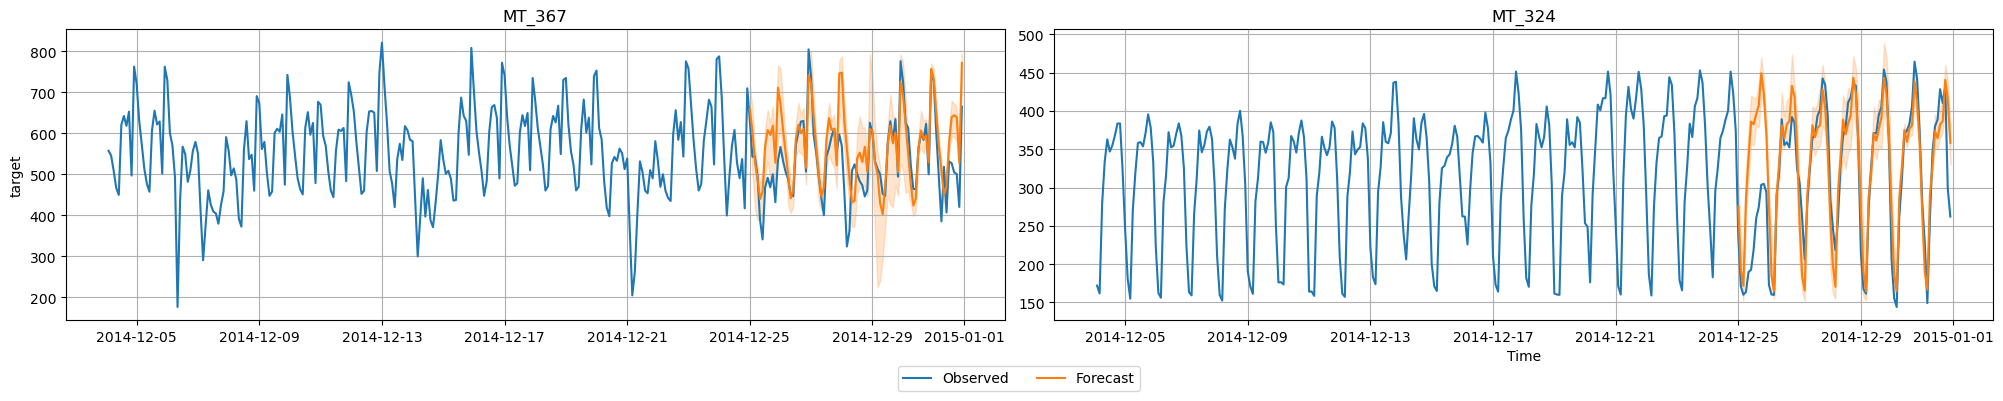

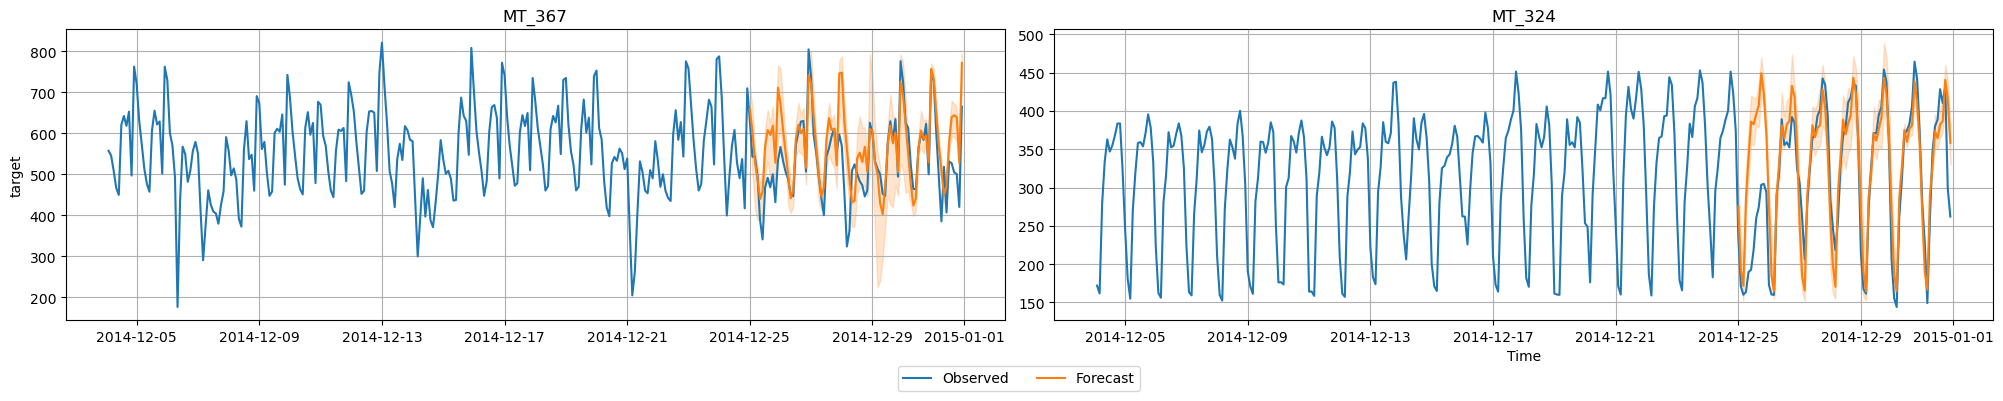

In [272]:
chronos_predictor_ag.plot(
    data=ts_sample_df.slice_by_timestep(start_index=-4*prediction_length, end_index=-1),
    predictions=prediction_df,
    item_ids=ts_sample_df.item_ids[0:2],
)

### Calculate metrics

This notebook uses AutoGluon time series [metrics](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html) to evaluate the performance of Chronos models.

As in previous notebooks, this notebook uses the following metrics:
- [Weighted quantile loss (WQL)](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.WQL)
- [Mean absolute percentage error (MAPE)](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.MAPE)
- [Weighted absolute percentage error (WAPE)](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.WAPE)
- [Root mean squared error (RMSE)](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.RMSE)
- [Mean absolute scaled error (MASE)](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.MASE)

Note that AutoGluon flips the sign of a metric by multiplying by `-1`.

In [283]:
def get_scores(
    metrics,
    data: TimeSeriesDataFrame,
    predictions: TimeSeriesDataFrame,
    prediction_length: int = prediction_length
)-> dict:
    kwargs = {
        'data': data,
        'predictions': predictions,
        'prediction_length': prediction_length,
    }

    return {m.__class__.__name__:m(**kwargs) for m in metrics}

In [284]:
metrics = [WQL(), MAPE(), WAPE(), RMSE(), MASE()]

In [285]:
get_scores(metrics, ts_sample_df.slice_by_timestep(end_index=-1), prediction_df)

{'WQL': -0.08026524552349422,
 'MAPE': -0.13359973242626827,
 'WAPE': -0.11286334437557502,
 'RMSE': -66.07395456826534,
 'MASE': -1.7614956522438396}

In the following sections **Backtest** and **Backtest with multiple windows** you calculate metrics for all deployed Chronos models.

### How context length impacts model accuracy

Let's see how the context length sent to a Chronos model affects model accuracy. The following code sends different number of time steps of the target time series to the predictor. 

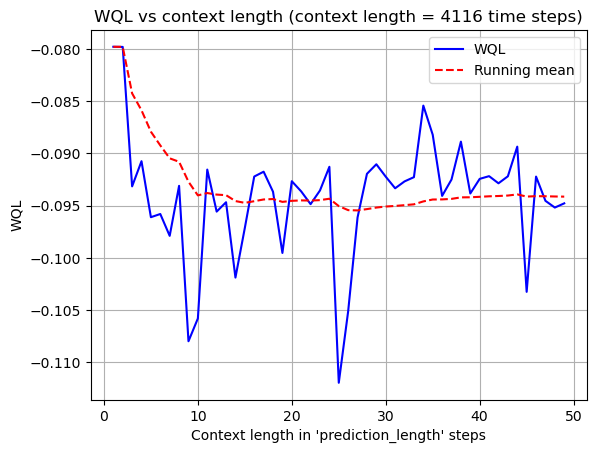

In [286]:
# Set up the plot
plt.figure(figsize=(10, 6))
plt.title("WQL vs context length")
plt.xlabel("Context length in 'prediction_length' steps")
plt.ylabel("WQL")
    
x_data = []
y_data = []
mean_data = []
n_context_length_steps = 50

for i in range(1, n_context_length_steps):
    # Calculate and store scores
    x_data.append(i)
    y_data.append(get_scores(
        [WQL()], 
        ts_sample_df.slice_by_timestep(end_index=-1),
        predict_ag(
            ts_sample_df.slice_by_timestep(
                start_index=-prediction_length*(i+1),
                end_index=-prediction_length-1
            ), 
            prediction_length=prediction_length,
            display_details=False,
        )# predict for each context length
    )['WQL'])
    mean_data.append(np.mean(y_data))
        
    # Clear the previous plot
    clear_output(wait=True)
        
    # Create new plot
    plt.clf()
    plt.plot(x_data, y_data, 'b-', label='WQL')
    plt.plot(x_data, mean_data, 'r--', label='Running mean')
    plt.title(f"WQL vs context length (context length = {i*prediction_length} time steps)")
    plt.xlabel("Context length in 'prediction_length' steps")
    plt.ylabel("WQL")
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.pause(0.1)  # Pause to allow the plot to update
    
plt.show()  # Show the final plot

As you can see, prediction accuracy isn't significantly affected by the context length provided you suplly the model with at least `prediction length` data points. For this specific sample of time series, the best context length is around one or two times the `prediction length`. If you send more data points to the model it can be "distracted" by more data and prediction accuracy decreases. For other datasets with more pronounced seasonal trends or long sequences results can be different.

As Chronos models are pretrained models and can work with any context and prediction lengths, you can experiment with `prediction_length` on your own and see how it impacts on prediction accuracy.

### Backtest

<div class="alert alert-info">
To reduce the inference time of Chronos endpoints you can use a subset of time series instead of the full dataset with 370 time series.
</div>

For AWS-led workshop please choose a small dataset by leaving the `USE_FULL_DATASET` on it's default value `False`. The inference time for the small dataset is about XXX minutes depending on the model size used. The inference time for the full dataset is about XXX minutes depending .... 

In [287]:
USE_FULL_DATASET = False

In [288]:
ts_df = get_ts_df(data_kw if USE_FULL_DATASET else data_kw_small)
ts_df

target
item_id timestamp                      
MT_367  2011-01-01 00:00:00    0.000000
        2011-01-01 02:00:00    0.000000
        2011-01-01 04:00:00    0.000000
        2011-01-01 06:00:00    0.000000
        2011-01-01 08:00:00    0.000000
...                                 ...
MT_324  2014-12-31 16:00:00  410.255282
        2014-12-31 18:00:00  431.659331
        2014-12-31 20:00:00  298.514525
        2014-12-31 22:00:00  262.070863
        2015-01-01 00:00:00   27.803697

[35066 rows x 1 columns]

#### Save the model performance to a file

### Backtest with multiple windows

In [ ]:
# offset: -24
# prediction_length: 24
# num_rolls: 1

In [1]:


n_windows = 4
splitter = ExpandingWindowSplitter(prediction_length=prediction_length, num_val_windows=n_windows)
item_ids = ts_df.item_ids[:2]
scores = []

for window_idx, (_, val_split) in enumerate(splitter.split(ts_df.slice_by_timestep(end_index=-1))):
    # predict
    split_prediction_df = predict_ag(
        val_split.slice_by_timestep(end_index=-prediction_length),
        prediction_length=prediction_length
    )
    
    # visualize
    chronos_predictor_ag.plot(
        data=ts_df.slice_by_timestep(start_index=-n_windows*prediction_length),
        predictions=split_prediction_df,
        item_ids=item_ids,
    )
    # evaluate
    score = wql(
        data=val_split,
        predictions=split_prediction_df,
        prediction_length=prediction_length,
    )
    
    print(f"Window {window_idx}: score = {score}")
    scores.append(score)

NameError: name 'ExpandingWindowSplitter' is not defined

#### Save the model performance to a file

### Alternative approaches to backtest

Giving the input time series and predictions, you can calculate the model performance using any approach. For example, you can use [GluonTS](https://ts.gluon.ai/stable/index.html) library for Chronos forecast evaluation as described in [evaluating Chronos models](https://github.com/amazon-science/chronos-forecasting/tree/main/scripts#evaluating-chronos-models) section of Chronos documentation.

## Pre-train and fine-tune Chronos models

If you want to train a Chronos model on your historical data and for your specific business domain, you can pre-train and fine-tune a foundation model. Start with the [documentation](https://github.com/amazon-science/chronos-forecasting/tree/main/scripts#pretraining-and-fine-tuning-chronos-models) on the Chronos GitHub.

## Using LLMs for zero-shot time series forecast

If you're interested in this approach to use LLMs for time series prediction, you might look at alternative models:
- [**ForecastPFN**](https://arxiv.org/abs/2311.01933): ForecastPFN tackles zero-shot forecasting by training a transformer-based model on synthetic data. While it shows promise, it's limited to generating point forecasts rather than probabilistic ones like Chronos. See ForecastPFN GitHub [repo](https://github.com/abacusai/ForecastPFN) for the source code and examples.
- [**LLMTime**](https://arxiv.org/pdf/2310.07820): LLMTime, developed by Gruver et al., shows zero-shot performance comparable to or exceeding purpose-built time series models. It uses models like GPT-3 and LLaMA-2 to extrapolate time series data encoded as strings of numerical digits. See LLMTime GitHub [repo](https://github.com/ngruver/llmtime) for the source code.
- [**LSTPrompt**](https://arxiv.org/abs/2402.16132): LSTPrompt exhibits enhanced long-term prediction stability compared to LLMTime. It uses a novel prompt paradigm with modules like TimeDecomp and TimeBreath to improve zero-shot forecasting accuracy. See also LSTPrompt GitHub [repo](https://github.com/AdityaLab/lstprompt)
- [**TimeGPT**](https://arxiv.org/abs/2310.03589): TimeGPT by [Nixtla](https://docs.nixtla.io/) was one of the first foundation models developed for forecasting.

---

## Clean up

In [194]:
for p in chronos_predictors.values():
    print(f"Deleting endpont {p.endpoint_name}")
    p.delete_endpoint()

Deleting endpont autogluon-forecasting-chronos-t5-small-2024-09-14-08-45-07-821


## Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>